In [23]:
import os

print(os.getcwd()) 

/home/alan_a/d3pm


In [25]:
%load_ext autoreload
%autoreload 2
    
from d3pm_sc.d3pm import D3PM
from d3pm_sc.unet import UNet

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import make_grid
from tqdm import tqdm

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
N = 4  # number of classes for discretized state per pixel
n_T = 1000
n_channel = 3
schedule_conditioning = True
d3pm = D3PM(UNet(n_channel, N, n_T, schedule_conditioning),
            n_T, num_classes=N, hybrid_loss_coeff=0.0).cuda()
print(f"Total Param Count: {sum([p.numel() for p in d3pm.x0_model.parameters()])}")
dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=16)


Total Param Count: 63314240
Files already downloaded and verified


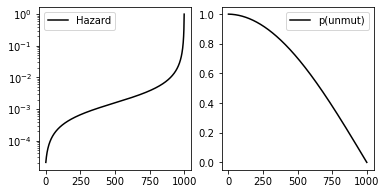

In [28]:
fig, ax = plt.subplots(1, 2, figsize=[6, 3])
ax[0].semilogy(d3pm.beta_t, label="Hazard", color='black')
ax[0].legend()

steps = torch.arange(d3pm.n_T + 1, dtype=torch.float64) / d3pm.n_T
alpha_bar = torch.cos((steps + 0.008) / 1.008 * torch.pi / 2)
ax[1].plot(alpha_bar, label="p(unmut)", color='black')
ax[1].legend()

In [29]:
optim = torch.optim.AdamW(d3pm.x0_model.parameters(), lr=1e-3)
d3pm.train()

n_epoch = 14
device = "cuda"

global_step = 0
for i in range(n_epoch):

    pbar = tqdm(dataloader)
    loss_ema = None
    for x, cond in pbar:
        optim.zero_grad()
        x = x.to(device)
        cond = cond.to(device)

        # discritize x to N bins
        x = (x * (N - 1)).round().long().clamp(0, N - 1)
        loss, info = d3pm(x, cond)

        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(d3pm.x0_model.parameters(), 0.1)

        with torch.no_grad():
            param_norm = sum([torch.norm(p) for p in d3pm.x0_model.parameters()])

        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.99 * loss_ema + 0.01 * loss.item()
        pbar.set_description(
            f"loss: {loss_ema:.4f}, norm: {norm:.4f}, param_norm: {param_norm:.4f}, vb_loss: {info['vb_loss']:.4f}, ce_loss: {info['ce_loss']:.4f}"
        )
        optim.step()
        global_step += 1

        if global_step % 300 == 1:
            d3pm.eval()

            with torch.no_grad():
                cond = torch.arange(0, 4).cuda() % 10
                init_noise = torch.randint(0, N, (4,)+x.shape[1:]).cuda()

                images = d3pm.sample_with_image_sequence(
                    init_noise, cond, stride=40
                )
                # image sequences to gif
                gif = []
                for image in images:
                    x_as_image = make_grid(image.float() / (N - 1), nrow=2)
                    img = x_as_image.permute(1, 2, 0).cpu().numpy()
                    img = (img * 255).astype(np.uint8)
                    gif.append(Image.fromarray(img))

                gif[0].save(
                    f"contents/sample_{global_step}.gif",
                    save_all=True,
                    append_images=gif[1:],
                    duration=100,
                    loop=0,
                )

                last_img = gif[-1]
                last_img.save(f"contents/sample_{global_step}_last.png")

            d3pm.train()

loss: 1.4459, norm: 2.5265, param_norm: 1236.0664, vb_loss: 1.4459, ce_loss: 1.5
0it [00:00, ?it/s]
10it [00:00, 93.19it/s]
21it [00:00, 102.51it/s]
32it [00:00, 105.85it/s]
43it [00:00, 107.41it/s]
54it [00:00, 108.18it/s]
65it [00:00, 108.69it/s]
76it [00:00, 109.04it/s]
87it [00:00, 109.11it/s]
98it [00:00, 109.25it/s]
109it [00:01, 109.46it/s]
120it [00:01, 109.60it/s]
131it [00:01, 109.69it/s]
142it [00:01, 109.71it/s]
153it [00:01, 109.75it/s]
165it [00:01, 109.88it/s]
176it [00:01, 109.83it/s]
188it [00:01, 109.96it/s]
200it [00:01, 110.08it/s]
212it [00:01, 110.06it/s]
224it [00:02, 110.13it/s]
236it [00:02, 110.17it/s]
248it [00:02, 110.19it/s]
260it [00:02, 110.14it/s]
272it [00:02, 110.14it/s]
284it [00:02, 110.08it/s]
296it [00:02, 110.18it/s]
308it [00:02, 110.22it/s]
320it [00:02, 110.23it/s]
332it [00:03, 110.24it/s]
344it [00:03, 110.24it/s]
356it [00:03, 110.19it/s]
368it [00:03, 110.27it/s]
380it [00:03, 110.24it/s]
392it [00:03, 110.14it/s]
404it [00:03, 110.17it/s]


KeyboardInterrupt: 

In [55]:
torch.save(d3pm.state_dict(), 'models/d3pm_cifar10_aug10')

In [17]:
images[0].shape

torch.Size([2, 3, 32, 32])

In [38]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

n_samples = 2

cond = torch.zeros(n_samples).cuda().to(torch.int64)
init_noise = torch.randint(0, N, (n_samples, n_channel, 32, 32)).cuda()

images = d3pm.sample_with_image_sequence(
    init_noise, cond, stride=1
)
images = torch.cat([im[None, ...] for im in images], 0)
images = torch.cat([init_noise[None, ...], images], 0)
diffs = (images[1:] != images[:-1]).reshape(n_samples, n_T-1, -1)

999it [00:08, 115.69it/s]


In [37]:
images[1:] 

tensor([], device='cuda:0', size=(0, 2000, 3, 32, 32), dtype=torch.int64)

/tmp/ipykernel_99061/2451614090.py:1: RuntimeWarning: Mean of empty slice.
  r1 = diffs.cpu().numpy().mean(0).mean(-1)[::-1]
/home/alan_a/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


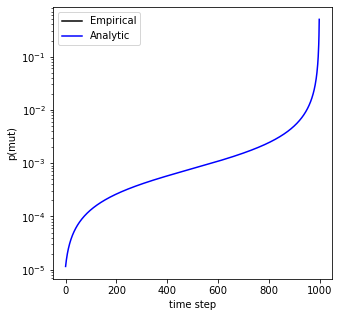

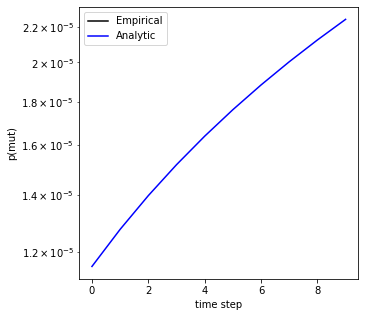

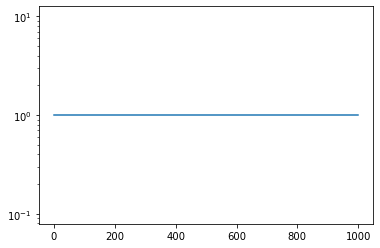

In [32]:
r1 = diffs.cpu().numpy().mean(0).mean(-1)[::-1]
r2 = d3pm.beta_t[1:].cpu().numpy() / 2
plt.figure(figsize=[5, 5])
plt.semilogy(r1, label="Empirical", color='black')
plt.semilogy(r2, label="Analytic", color='blue')
plt.xlabel("time step")
plt.ylabel("p(mut)")
plt.legend()
# plt.savefig("figures/schedule_comparison.png")

plt.figure(figsize=[5, 5])
plt.semilogy(r1[:10], label="Empirical", color='black')
plt.semilogy(r2[:10], label="Analytic", color='blue')
plt.xlabel("time step")
plt.ylabel("p(mut)")
plt.legend()
# plt.savefig("figures/schedule_comparison_zoom.png")

plt.figure()
plt.semilogy(r1/r2, color='black')
plt.plot([0, 1000], np.ones(2))

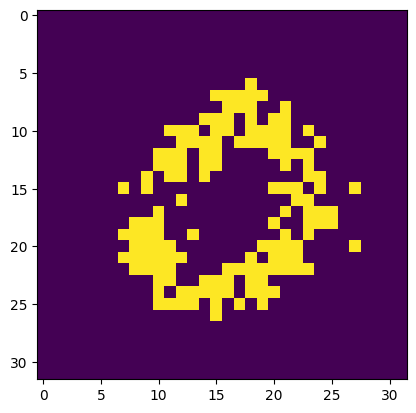

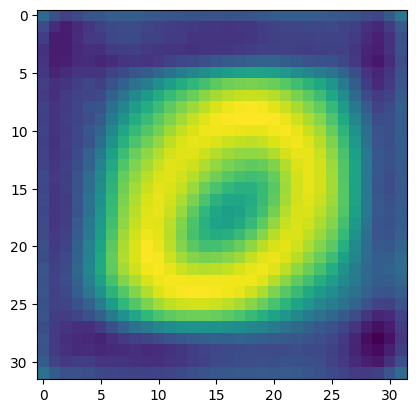

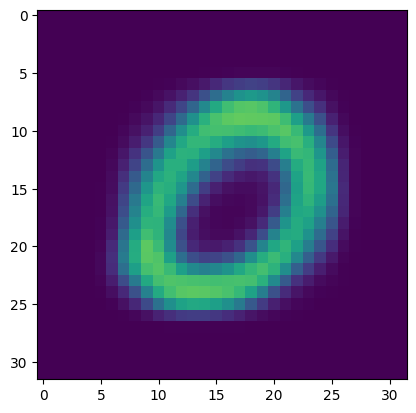

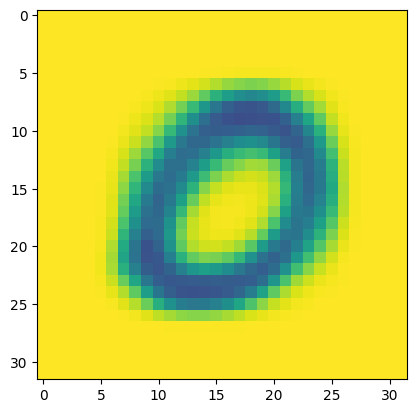

In [38]:
with torch.no_grad():
    t = 1#d3pm.n_T-1
    t = torch.tensor([t], device=init_noise.device)
    x = images[[1]][:, [-2]]
    preds = d3pm.x0_model(x, t, cond[[0]])
    ps = d3pm.q_posterior_logits(preds, x, t)
    
    preds = preds.squeeze()
    preds = preds.cpu().numpy()[:, :, -1]
    plt.imshow(x.squeeze().cpu().numpy())
    plt.figure()
    plt.imshow(preds)#, vmin=0, vmax=1)
    plt.figure()
    ps = ps.squeeze()
    ps = torch.softmax(ps, dim=-1).cpu().numpy()
    plt.imshow(ps[:, :, -1], vmin=0, vmax=1)
    plt.figure()
    plt.imshow(ps[:, :, 0], vmin=0, vmax=1)

In [47]:
# r1 = d3pm.beta_t[100:-1]
# r2 = rates[100:]
kl = r1 * (np.log(r1) - np.log(r2)) + (1-r1) * (np.log(1-r1) - np.log(1-r2))
print(kl.sum())

1.117064540897708


Text(0.5, 0, 'step')

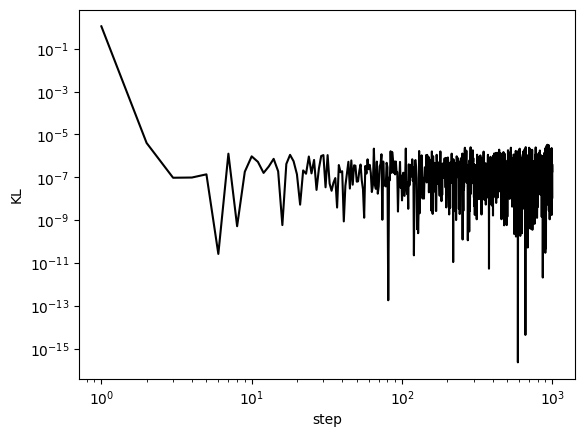

In [59]:
plt.loglog(np.arange(1, 1000), kl, color='black')
plt.ylabel("KL")
plt.xlabel("step")